# Satrical Article Analysis Using Naive Bayes

In [52]:
import re
import string
import random
from collections import Counter

# pip install nltk
import nltk
import pandas as pd
import numpy as np
import sklearn
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split



nltk.download('stopwords')
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to C:\Users\Ty
[nltk_data]     Lovgren\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Part 1: Data Preprocessing

In [53]:
# TODO: Update for what is important for article titles
def clean_data(review):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    review = review.lower()
    review = emoji_pattern.sub(r'', review)   
    review=re.sub("isn't",'is not',review)
    review=re.sub("he's",'he is',review)
    review=re.sub("she's",'she is',review)
    review = re.sub("isn't", "is not", review)
    review = re.sub("aren't", "are not", review)
    review = re.sub("wasn't", "was not", review)
    review = re.sub("weren't", "were not", review)
    review = re.sub("haven't", "have not", review)
    review = re.sub("hasn't", "has not", review)
    review = re.sub("hadn't", "had not", review)
    review = re.sub("won't", "will not", review)
    review = re.sub("wouldn't", "would not", review)
    review = re.sub("don't", "do not", review)
    review = re.sub("doesn't", "does not", review)
    review = re.sub("didn't", "did not", review)
    review = re.sub("can't", "cannot", review)
    review = re.sub("couldn't", "could not", review)
    review = re.sub("shouldn't", "should not", review)
    review = re.sub("mightn't", "might not", review)
    review = re.sub("mustn't", "must not", review)
    review = re.sub("he's", "he is", review)
    review = re.sub("she's", "she is", review)
    review = re.sub("it's", "it is", review)
    review = re.sub("that's", "that is", review)
    review = re.sub("there's", "there is", review)
    review = re.sub("here's", "here is", review)
    review = re.sub("who's", "who is", review)
    review = re.sub("what's", "what is", review)
    review = re.sub("where's", "where is", review)
    review = re.sub("when's", "when is", review)
    review = re.sub("why's", "why is", review)
    review = re.sub("how's", "how is", review)
    review = re.sub("I'm", "I am", review)
    review = re.sub("you're", "you are", review)
    review = re.sub("they're", "they are", review)
    review = re.sub("we're", "we are", review)
    review = re.sub("I've", "I have", review)
    review = re.sub("you've", "you have", review)
    review = re.sub("they've", "they have", review)
    review = re.sub("we've", "we have", review)
    review = re.sub("I'll", "I will", review)
    review = re.sub("you'll", "you will", review)
    review = re.sub("he'll", "he will", review)
    review = re.sub("she'll", "she will", review)
    review = re.sub("it'll", "it will", review)
    review = re.sub("they'll", "they will", review)
    review = re.sub("we'll", "we will", review)
    review = re.sub("I'd", "I would", review)
    review = re.sub("you'd", "you would", review)
    review = re.sub("he'd", "he would", review)
    review = re.sub("she'd", "she would", review)
    review = re.sub("it'd", "it would", review)
    review = re.sub("they'd", "they would", review)
    review = re.sub("we'd", "we would", review)
    review = re.sub(r"\n", " ", review)
    review = re.sub(r"\W", " ", review)
    review = re.sub(r"\d", " ", review)


    return review

In [54]:
###########################
# Onion Article Importing #
###########################

# Onion Dataset columns (post rename): title, satirical
# Satirical column key:
# 0 = onion like article
# 1 = onion article

# Converting onion & like onion articles csv into df
onion_dataset = pd.read_csv("./Data_Exploration/Satire_HeadLines_Source/OnionOrNot.csv")

# Renaming columns for consistency
onion_dataset = onion_dataset.rename(columns= {"text": "title", "label": "satirical"})

# Collecting indexes of like onion articles
non_onion_articles = onion_dataset[onion_dataset["satirical"] == 0].index

# Dropping like onion articles from the dataset
onion_articles = onion_dataset.drop(non_onion_articles)


##########################
# Real Article Importing #
##########################

# Converting real articles source csv into df
real_articles = pd.read_csv("./Data_Exploration/Genuine_HeadLines_Source/True.csv")

# Dropping non-relevant details
real_articles = real_articles.drop(columns= {"text","subject","date"})

# Adding satirical key to mark articles as real articles
real_articles["satirical"] = 0

# Logging 
# print(onion_sources.columns)
# print(onion_sources.iloc[0])
# print(real_sources.columns)
# print(real_sources.iloc[0])


# Columns: title, satirical
# satirical column key:
# 0 = non-satiricial article
# 1 = satirical article

# Merging of real and onion articles
combined_articles = pd.concat([onion_articles, real_articles], ignore_index=True)


# Cleaning the title column
combined_articles['cleaned_title'] = combined_articles['title'].apply(clean_data)

# Dropping non-cleaned titles
combined_articles = combined_articles[['cleaned_title', 'satirical']]

In [55]:
#  Removal of stop words from combined article dataset
combined_articles['no_sw'] = combined_articles['cleaned_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

## To Do: Do we need these next 3

In [56]:
# find value counts of all words in all data points
counter = Counter()
for text in combined_articles["no_sw"].values:
    for word in text.split():
        counter[word] += 1

# creates a set of the 10 most common words amongst all reviews
FREQWORDS = set([w for (w, wc) in counter.most_common(10)])

In [57]:
def remove_freqwords(text, freqwords):
    '''Given a tweet that has been cleaned, returns the tweet without the most frequently appearing words'''
    for word in freqwords:
        text = re.sub(word, " ", text)

    return text


# remove frequent words that do not add value to the model
combined_articles["no_sw"] = combined_articles["no_sw"].apply(lambda text: remove_freqwords(text, FREQWORDS))

In [58]:
tokenized_data = combined_articles.drop(columns=['cleaned_title'])
tokenized_data.columns = ['satirical', 'cleaned_title']

tokenized_data["cleaned_title"] = tokenized_data["cleaned_title"].apply(lambda t: t.split())


Part 2: Naive Bayes Implementation

In [59]:
import math
import random


class NaiveBayesModel:
    '''Class representing the implementation of the Naive Bayes model'''

    def __init__(self) -> None:
        self.occurrence_table = {}
        self.probability_table = {}
        self.labels = []
        

    def train_model(self, data, labels):
        '''Runs the training process for the model, building the occurrence table and probability table'''
        self.build_occurrence_table(data, labels)
        self.build_probability_table()


    def build_occurrence_table(self, data, labels):
        '''Private function to create the occurrence table given the training data and labels'''
        for words, label in zip(data,labels):
            for word in words:
                if word not in self.occurrence_table.keys():
                    self.occurrence_table[word] = {0: 1, 1: 1, 2: 1}
                self.occurrence_table[word][label] += 1

                
        

    def build_probability_table(self):
        '''Private function to create the probability table based on the occurrence table'''
        for word in self.occurrence_table.keys():
            self.probability_table[word] = {0: 0, 1: 0, 2: 0}         
            sum =  self.occurrence_table[word][0] + self.occurrence_table[word][1] + self.occurrence_table[word][2]
            i = 0
            while i < 3:
                self.probability_table[word][i] = self.occurrence_table[word][i] / sum
                i += 1
            
            

    def predict(self, variables):
        '''Takes a set of variables, and predicts the class they should belong to'''
        
        predictions = []
        for words in variables:
            positive = []
            negative = []
            neutral = []
            for word in words:
                if word in self.probability_table.keys():
                    negative.append(self.probability_table[word][0])
                    neutral.append(self.probability_table[word][1])
                    positive.append(self.probability_table[word][2])
                else:
                    smoothing = 1 / (len(self.probability_table.keys()) + len(words))
                    negative.append(smoothing)
                    neutral.append(smoothing)
                    positive.append(smoothing)
            negative_prob = 1
            for value in negative:
                negative_prob = negative_prob * value
            neutral_prob = 1
            for value in neutral:
                neutral_prob = neutral_prob * value
            positive_prob = 1
            for value in positive:
                positive_prob = positive_prob * value
            
            if(negative_prob > neutral_prob and negative_prob > positive_prob):
                predictions.append(0)
            elif(neutral_prob > negative_prob and neutral_prob > positive_prob):
                predictions.append(1)
            elif(positive_prob > negative_prob and positive_prob > neutral_prob):
                predictions.append(2)
            elif(negative_prob == neutral_prob and negative_prob > positive_prob):
                predictions.append(random.randint(0, 1))
            elif(negative_prob == positive_prob and negative_prob > neutral_prob):
                rand_int = random.randint(0, 1)
                if(rand_int == 1):
                    predictions.append(2)
                else:
                    predictions.append(0)
            elif(neutral_prob == positive_prob and neutral_prob > negative_prob):
                predictions.append(random.randint(1, 2))
            else:
                predictions.append(random.randint(0, 2))

        return predictions
                




In [60]:
print("Tokenized data sample:")
print(tokenized_data.head())
print("Number of rows:", len(tokenized_data))

#TODO Change for new data set 
data_train, data_test, label_train, label_test = train_test_split(tokenized_data["cleaned_title"], tokenized_data["satirical"], test_size=0.2, shuffle=True)

print("Empty cleaned titles:", tokenized_data[tokenized_data["cleaned_title"].str.len() == 0])

#TODO train and predict using the Naive Bayes model implementation
naivebayes = NaiveBayesModel()
naivebayes.train_model(data_train, label_train)
predicted_data = naivebayes.predict(data_test) 



Tokenized data sample:
   satirical                                      cleaned_title
0          1  [entire, facebook, staff, laughs, tightens, pr...
1          1  [bold, move, hulu, announced, gonna, ahead, re...
2          1  [despondent, jeff, bezos, realizes, work, seco...
3          1  [great, single, women, online, dating, offers,...
4          1  [jong, wonders, nuclear, threats, distracting,...
Number of rows: 30417
Empty cleaned titles:        satirical cleaned_title
22             1            []
611            1            []
1746           1            []
1906           1            []
4241           1            []
4242           1            []
4925           1            []
5744           1            []
8405           1            []
8448           1            []
15550          0            []
21196          0            []


[[4247   40]
 [ 467 1326]]


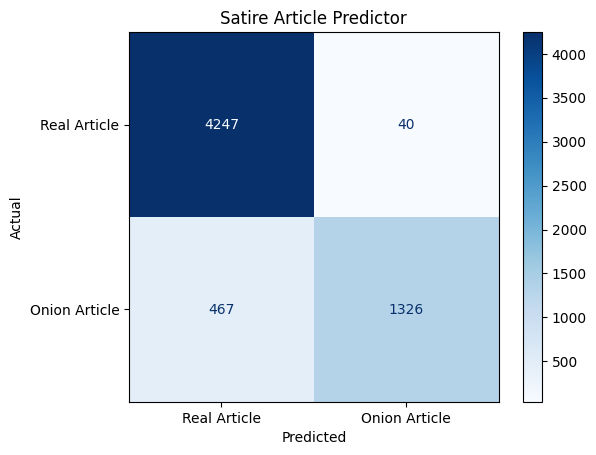

Accuracy: 0.916009204470743
Precision: 0.9215336732164465
Recall: 0.916009204470743
F Score: 0.9126138356676043


C:\Users\Ty Lovgren\AppData\Roaming\Python\Python313\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [63]:
import matplotlib.pyplot as plt
import sklearn.metrics as metrics

conf_matrix = metrics.confusion_matrix(label_test, predicted_data, labels=[0,1])
print(conf_matrix)
display = metrics.ConfusionMatrixDisplay(confusion_matrix= conf_matrix, display_labels=["Real Article","Onion Article"])
display.plot(cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Satire Article Predictor")
plt.show()

accuracy = metrics.accuracy_score(label_test, predicted_data)
print(f"Accuracy: {accuracy}")
precision = metrics.precision_score(label_test, predicted_data, average= "weighted")
print(f"Precision: {precision}")
recall = metrics.recall_score(label_test, predicted_data, average="weighted")
print(f"Recall: {recall}")
f_score = metrics.f1_score(label_test, predicted_data, average="weighted")
print(f"F Score: {f_score}")